## Dipole Current Distribution using Method of Moments
As described in Antenna Theory and Design by Constantine Balanis

### Imports

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

### Specify Geometry

We are simulating a dipole of length $l$ and width $a$ in wavelength units. To enable a numerical solution via the Method of Moments, we must discretize it into $N$ segments.

<img src="Geometry.png" width=300>

In [235]:
N = 101 # Number of Segments
l = 0.5*5 # Length in wavelengths
a = 0.005 # Radius in wavelengths
fp = 0.5 # Feed position as fraction of total length

### Current Distribution Calculation

We find current distribution by solving Pocklington's Integral Equation:

$\int^{l/2}_{-l/2}{I_z(z')}[(\frac{\partial^2}{\partial z^2} + k^2)G(z,z')] dz' = -j\omega \epsilon E_z^i (\rho = a)$

However we have made the approximation that the wire is very thin ($a \ll \lambda$) which reduces the equation to:

$\int^{l/2}_{-l/2}{I_z(z')} \frac{e^{-jkR}}{4 \pi R^5} [(1+jkR)(2R^2-3a^2) + (kaR)^2] dz' = -j\omega \epsilon E_z^i (\rho = a)$

In [236]:
def pock_eqn(zm, zn, a):
    k = 2*np.pi
    R = np.sqrt(a**2+(zm-zn)**2)
    return np.exp(-1j*k*R)/(4*np.pi*R**5)*((1+1j*k*R)*(2*R**2-3*a**2)+(k*a*R)**2)

#### Solve for Current Distribution using Method of Moments
We can assume that the total current distribution is a linear combination of $N$ basis functions with unknown coefficients:

<img src="Basis.png" width=600>

Evaluating the integral for a particular value of $z$ can be done by summing up the contributions of each basis function at each observation point $z'$. This leads to a single equation with $N$ unknowns. However if we instead evaluate this at $N$ values of $z$ for which we already know the result, we form $N$ equations. The unknown coefficients can then be solved for which correspond to the current in each segment.

In [237]:
delta = l/N # Segment length
E = np.zeros((N,1), dtype=complex)
Z = np.zeros((N,N), dtype=complex)

# Delta Gap Source Initialisation
E[int(np.floor(N*fp))] = -1j*2*np.pi/(120*np.pi*delta);

# Impedance Matrix Population
for m in tqdm(range (N)):
    zm = -l/2+(m+0.5)*delta
    for n in range (N):
        zn = -l/2+(n+0.5)*delta
        Z[m,n] = integrate.romberg(lambda x: pock_eqn(zm, x, a), zn-0.5*delta, zn+0.5*delta)

# Solve
I = np.linalg.solve(Z,E)

100%|██████████| 101/101 [00:01<00:00, 71.24it/s]


#### Normalized Current Distribution Plot

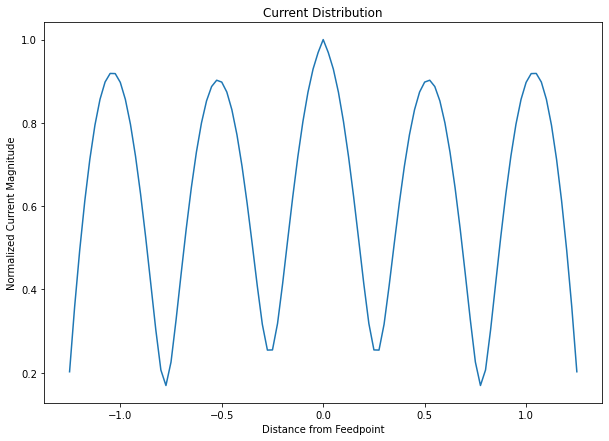

In [243]:
plt.figure(figsize=(10,7));
plt.plot(np.linspace(0,l,N) - l/2, np.abs(I / np.max(np.abs(I))));
plt.title("Current Distribution");
plt.xlabel("Distance from Feedpoint");
plt.ylabel("Normalized Current Magnitude");

### Radiation Pattern Calculation

#### Infinitesimal Dipole Far-Field E

In [239]:
def inf_dipole_E(theta, r, I):
    k = 2*np.pi
    return I*np.sin(theta)/r*np.exp(1j*k*r)

#### Sum up contributions from each segment treated as an infinitesimal dipole

In [240]:
res = 1000
r = 10000
E_theta = np.zeros(res, dtype=complex)
for s in tqdm(range(res)):
    theta = s/res*np.pi*2
    (z,x) = (r*np.cos(theta),r*np.sin(theta))
    for m in range(N):
        zm = -l/2+(m+0.5)*delta
        r_m = np.sqrt(x**2+(z-zm)**2)
        E_theta[s] += inf_dipole_E(theta, r_m, I[m])

100%|██████████| 1000/1000 [00:01<00:00, 856.99it/s]


#### Plot Result

C:\Users\Jordan\AppData\Local\Temp\ipykernel_8488\4239726842.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.polar(np.linspace(0,2*np.pi,res), 20*np.log10(normalised_E));


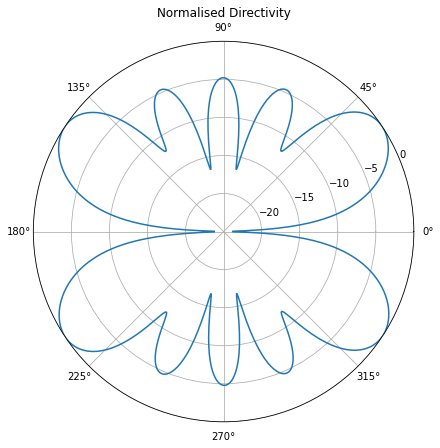

In [241]:
plt.figure(figsize=(7,7));
normalised_E = np.abs(E_theta)/np.max(np.abs(E_theta))
plt.polar(np.linspace(0,2*np.pi,res), 20*np.log10(normalised_E));
plt.ylim([-25,0]);
plt.title("Normalised Directivity");

### Impedance Calculation

In [242]:
z = 1/I[int(np.floor(N/2))]
print(z[0])

(127.76521237304414-35.113869909290784j)
